In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'silu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

silu_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:43 - loss: 2.0442 - STD: 0.0071 - MAE: 0.2176

 5/78 [>.............................] - ETA: 1s - loss: 1.4627 - STD: 0.1585 - MAE: 0.1575  

 9/78 [==>...........................] - ETA: 1s - loss: 1.3847 - STD: 0.1779 - MAE: 0.1492

13/78 [====>.........................] - ETA: 0s - loss: 1.3391 - STD: 0.1821 - MAE: 0.1470

17/78 [=====>........................] - ETA: 0s - loss: 1.3041 - STD: 0.1870 - MAE: 0.1445

21/78 [=======>......................] - ETA: 0s - loss: 1.2747 - STD: 0.1901 - MAE: 0.1426

25/78 [========>.....................] - ETA: 0s - loss: 1.2503 - STD: 0.1940 - MAE: 0.1406

29/78 [==========>...................] - ETA: 0s - loss: 1.2300 - STD: 0.1963 - MAE: 0.1392

33/78 [===========>..................] - ETA: 0s - loss: 1.2089 - STD: 0.1976 - MAE: 0.1382

37/78 [=============>................] - ETA: 0s - loss: 1.1886 - STD: 0.1993 - MAE: 0.1369

41/78 [==============>...............] - ETA: 0s - loss: 1.1704 - STD: 0.2007 - MAE: 0.1359

45/78 [================>.............] - ETA: 0s - loss: 1.1542 - STD: 0.2020 - MAE: 0.1349

49/78 [=================>............] - ETA: 0s - loss: 1.1396 - STD: 0.2034 - MAE: 0.1339

50/78 [==================>...........] - ETA: 0s - loss: 1.1387 - STD: 0.2040 - MAE: 0.1336

54/78 [===================>..........] - ETA: 0s - loss: 1.1259 - STD: 0.2053 - MAE: 0.1327

58/78 [=====================>........] - ETA: 0s - loss: 1.1158 - STD: 0.2064 - MAE: 0.1320

62/78 [======================>.......] - ETA: 0s - loss: 1.1065 - STD: 0.2074 - MAE: 0.1313

66/78 [========================>.....] - ETA: 0s - loss: 1.0971 - STD: 0.2077 - MAE: 0.1308

70/78 [=========================>....] - ETA: 0s - loss: 1.0876 - STD: 0.2085 - MAE: 0.1302

74/78 [===========================>..] - ETA: 0s - loss: 1.0787 - STD: 0.2095 - MAE: 0.1295

78/78 [==============================] - ETA: 0s - loss: 1.0700 - STD: 0.2104 - MAE: 0.1288

78/78 [==============================] - 4s 32ms/step - loss: 1.0700 - STD: 0.2104 - MAE: 0.1288 - val_loss: 0.9261 - val_STD: 0.2199 - val_MAE: 0.1202


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9113 - STD: 0.2196 - MAE: 0.1197

 4/78 [>.............................] - ETA: 1s - loss: 0.9058 - STD: 0.2263 - MAE: 0.1164

 8/78 [==>...........................] - ETA: 1s - loss: 0.9016 - STD: 0.2260 - MAE: 0.1162

12/78 [===>..........................] - ETA: 1s - loss: 0.8992 - STD: 0.2263 - MAE: 0.1160

16/78 [=====>........................] - ETA: 0s - loss: 0.8971 - STD: 0.2260 - MAE: 0.1161

20/78 [======>.......................] - ETA: 0s - loss: 0.8971 - STD: 0.2266 - MAE: 0.1158

24/78 [========>.....................] - ETA: 0s - loss: 0.8942 - STD: 0.2269 - MAE: 0.1155

28/78 [=========>....................] - ETA: 0s - loss: 0.9025 - STD: 0.2277 - MAE: 0.1155

32/78 [===========>..................] - ETA: 0s - loss: 0.9065 - STD: 0.2267 - MAE: 0.1161

36/78 [============>.................] - ETA: 0s - loss: 0.9065 - STD: 0.2262 - MAE: 0.1163

40/78 [==============>...............] - ETA: 0s - loss: 0.9055 - STD: 0.2260 - MAE: 0.1164

44/78 [===============>..............] - ETA: 0s - loss: 0.9033 - STD: 0.2263 - MAE: 0.1161

48/78 [=================>............] - ETA: 0s - loss: 0.9014 - STD: 0.2265 - MAE: 0.1159

52/78 [===================>..........] - ETA: 0s - loss: 0.8986 - STD: 0.2268 - MAE: 0.1156

56/78 [====================>.........] - ETA: 0s - loss: 0.8953 - STD: 0.2272 - MAE: 0.1153

60/78 [======================>.......] - ETA: 0s - loss: 0.8938 - STD: 0.2273 - MAE: 0.1152

64/78 [=======================>......] - ETA: 0s - loss: 0.8926 - STD: 0.2277 - MAE: 0.1149

68/78 [=========================>....] - ETA: 0s - loss: 0.8909 - STD: 0.2280 - MAE: 0.1147

72/78 [==========================>...] - ETA: 0s - loss: 0.8887 - STD: 0.2281 - MAE: 0.1146

76/78 [============================>.] - ETA: 0s - loss: 0.8866 - STD: 0.2282 - MAE: 0.1144

78/78 [==============================] - 1s 18ms/step - loss: 0.8854 - STD: 0.2282 - MAE: 0.1144 - val_loss: 0.8534 - val_STD: 0.2417 - val_MAE: 0.1075


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8576 - STD: 0.2458 - MAE: 0.1053

 4/78 [>.............................] - ETA: 1s - loss: 0.8462 - STD: 0.2353 - MAE: 0.1092

 8/78 [==>...........................] - ETA: 1s - loss: 0.8462 - STD: 0.2338 - MAE: 0.1099

12/78 [===>..........................] - ETA: 1s - loss: 0.8439 - STD: 0.2338 - MAE: 0.1097

16/78 [=====>........................] - ETA: 0s - loss: 0.8436 - STD: 0.2329 - MAE: 0.1101

20/78 [======>.......................] - ETA: 0s - loss: 0.8414 - STD: 0.2331 - MAE: 0.1099

24/78 [========>.....................] - ETA: 0s - loss: 0.8404 - STD: 0.2334 - MAE: 0.1097

28/78 [=========>....................] - ETA: 0s - loss: 0.8388 - STD: 0.2333 - MAE: 0.1097

32/78 [===========>..................] - ETA: 0s - loss: 0.8370 - STD: 0.2336 - MAE: 0.1094

36/78 [============>.................] - ETA: 0s - loss: 0.8351 - STD: 0.2340 - MAE: 0.1092

40/78 [==============>...............] - ETA: 0s - loss: 0.8425 - STD: 0.2343 - MAE: 0.1093

45/78 [================>.............] - ETA: 0s - loss: 0.8452 - STD: 0.2339 - MAE: 0.1098

49/78 [=================>............] - ETA: 0s - loss: 0.8464 - STD: 0.2333 - MAE: 0.1101

53/78 [===================>..........] - ETA: 0s - loss: 0.8465 - STD: 0.2329 - MAE: 0.1103

57/78 [====================>.........] - ETA: 0s - loss: 0.8453 - STD: 0.2332 - MAE: 0.1101

61/78 [======================>.......] - ETA: 0s - loss: 0.8440 - STD: 0.2332 - MAE: 0.1101

65/78 [========================>.....] - ETA: 0s - loss: 0.8424 - STD: 0.2334 - MAE: 0.1099

69/78 [=========================>....] - ETA: 0s - loss: 0.8402 - STD: 0.2334 - MAE: 0.1098

73/78 [===========================>..] - ETA: 0s - loss: 0.8383 - STD: 0.2336 - MAE: 0.1096

77/78 [============================>.] - ETA: 0s - loss: 0.8378 - STD: 0.2338 - MAE: 0.1094

78/78 [==============================] - 1s 18ms/step - loss: 0.8375 - STD: 0.2338 - MAE: 0.1095 - val_loss: 0.8281 - val_STD: 0.2261 - val_MAE: 0.1127


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8075 - STD: 0.2310 - MAE: 0.1093

 5/78 [>.............................] - ETA: 1s - loss: 0.8227 - STD: 0.2374 - MAE: 0.1068

 9/78 [==>...........................] - ETA: 1s - loss: 0.8263 - STD: 0.2353 - MAE: 0.1079

13/78 [====>.........................] - ETA: 0s - loss: 0.8239 - STD: 0.2353 - MAE: 0.1079

17/78 [=====>........................] - ETA: 0s - loss: 0.8192 - STD: 0.2354 - MAE: 0.1076

21/78 [=======>......................] - ETA: 0s - loss: 0.8166 - STD: 0.2356 - MAE: 0.1075

25/78 [========>.....................] - ETA: 0s - loss: 0.8161 - STD: 0.2359 - MAE: 0.1073

29/78 [==========>...................] - ETA: 0s - loss: 0.8126 - STD: 0.2363 - MAE: 0.1069

33/78 [===========>..................] - ETA: 0s - loss: 0.8095 - STD: 0.2365 - MAE: 0.1066

37/78 [=============>................] - ETA: 0s - loss: 0.8084 - STD: 0.2367 - MAE: 0.1065

41/78 [==============>...............] - ETA: 0s - loss: 0.8076 - STD: 0.2371 - MAE: 0.1063

45/78 [================>.............] - ETA: 0s - loss: 0.8049 - STD: 0.2372 - MAE: 0.1061

49/78 [=================>............] - ETA: 0s - loss: 0.8039 - STD: 0.2373 - MAE: 0.1060

52/78 [===================>..........] - ETA: 0s - loss: 0.8025 - STD: 0.2374 - MAE: 0.1059

56/78 [====================>.........] - ETA: 0s - loss: 0.8010 - STD: 0.2376 - MAE: 0.1057

60/78 [======================>.......] - ETA: 0s - loss: 0.8030 - STD: 0.2377 - MAE: 0.1057

64/78 [=======================>......] - ETA: 0s - loss: 0.8032 - STD: 0.2376 - MAE: 0.1058

68/78 [=========================>....] - ETA: 0s - loss: 0.8026 - STD: 0.2375 - MAE: 0.1058

72/78 [==========================>...] - ETA: 0s - loss: 0.8016 - STD: 0.2375 - MAE: 0.1058

76/78 [============================>.] - ETA: 0s - loss: 0.8007 - STD: 0.2377 - MAE: 0.1057

78/78 [==============================] - 1s 18ms/step - loss: 0.8000 - STD: 0.2378 - MAE: 0.1056 - val_loss: 0.7898 - val_STD: 0.2314 - val_MAE: 0.1094


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7717 - STD: 0.2355 - MAE: 0.1048

 5/78 [>.............................] - ETA: 1s - loss: 0.7973 - STD: 0.2413 - MAE: 0.1038

 9/78 [==>...........................] - ETA: 1s - loss: 0.7901 - STD: 0.2393 - MAE: 0.1044

13/78 [====>.........................] - ETA: 1s - loss: 0.7856 - STD: 0.2394 - MAE: 0.1042

17/78 [=====>........................] - ETA: 0s - loss: 0.7832 - STD: 0.2395 - MAE: 0.1040

21/78 [=======>......................] - ETA: 0s - loss: 0.7826 - STD: 0.2396 - MAE: 0.1039

25/78 [========>.....................] - ETA: 0s - loss: 0.7855 - STD: 0.2394 - MAE: 0.1042

29/78 [==========>...................] - ETA: 0s - loss: 0.7857 - STD: 0.2395 - MAE: 0.1042

33/78 [===========>..................] - ETA: 0s - loss: 0.7842 - STD: 0.2393 - MAE: 0.1042

37/78 [=============>................] - ETA: 0s - loss: 0.7830 - STD: 0.2394 - MAE: 0.1041

41/78 [==============>...............] - ETA: 0s - loss: 0.7825 - STD: 0.2396 - MAE: 0.1040

45/78 [================>.............] - ETA: 0s - loss: 0.7814 - STD: 0.2396 - MAE: 0.1039

49/78 [=================>............] - ETA: 0s - loss: 0.7800 - STD: 0.2397 - MAE: 0.1038

53/78 [===================>..........] - ETA: 0s - loss: 0.7813 - STD: 0.2397 - MAE: 0.1038

57/78 [====================>.........] - ETA: 0s - loss: 0.7807 - STD: 0.2399 - MAE: 0.1037

62/78 [======================>.......] - ETA: 0s - loss: 0.7793 - STD: 0.2398 - MAE: 0.1037

66/78 [========================>.....] - ETA: 0s - loss: 0.7778 - STD: 0.2400 - MAE: 0.1035

70/78 [=========================>....] - ETA: 0s - loss: 0.7764 - STD: 0.2401 - MAE: 0.1034

74/78 [===========================>..] - ETA: 0s - loss: 0.7748 - STD: 0.2403 - MAE: 0.1032

78/78 [==============================] - ETA: 0s - loss: 0.7758 - STD: 0.2404 - MAE: 0.1032

78/78 [==============================] - 1s 17ms/step - loss: 0.7758 - STD: 0.2404 - MAE: 0.1032 - val_loss: 1.1523 - val_STD: 0.2516 - val_MAE: 0.1095


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1552 - STD: 0.2523 - MAE: 0.1068

 5/78 [>.............................] - ETA: 1s - loss: 0.9813 - STD: 0.2412 - MAE: 0.1103

 9/78 [==>...........................] - ETA: 1s - loss: 0.9314 - STD: 0.2362 - MAE: 0.1114

13/78 [====>.........................] - ETA: 0s - loss: 0.9043 - STD: 0.2330 - MAE: 0.1119

17/78 [=====>........................] - ETA: 0s - loss: 0.8837 - STD: 0.2333 - MAE: 0.1110

21/78 [=======>......................] - ETA: 0s - loss: 0.8693 - STD: 0.2333 - MAE: 0.1105

25/78 [========>.....................] - ETA: 0s - loss: 0.8562 - STD: 0.2340 - MAE: 0.1096

29/78 [==========>...................] - ETA: 0s - loss: 0.8460 - STD: 0.2348 - MAE: 0.1088

33/78 [===========>..................] - ETA: 0s - loss: 0.8387 - STD: 0.2353 - MAE: 0.1083

37/78 [=============>................] - ETA: 0s - loss: 0.8312 - STD: 0.2357 - MAE: 0.1078

41/78 [==============>...............] - ETA: 0s - loss: 0.8247 - STD: 0.2363 - MAE: 0.1072

45/78 [================>.............] - ETA: 0s - loss: 0.8191 - STD: 0.2367 - MAE: 0.1067

49/78 [=================>............] - ETA: 0s - loss: 0.8144 - STD: 0.2370 - MAE: 0.1064

53/78 [===================>..........] - ETA: 0s - loss: 0.8095 - STD: 0.2373 - MAE: 0.1060

57/78 [====================>.........] - ETA: 0s - loss: 0.8053 - STD: 0.2377 - MAE: 0.1056

61/78 [======================>.......] - ETA: 0s - loss: 0.8014 - STD: 0.2380 - MAE: 0.1053

66/78 [========================>.....] - ETA: 0s - loss: 0.7981 - STD: 0.2385 - MAE: 0.1049

70/78 [=========================>....] - ETA: 0s - loss: 0.7953 - STD: 0.2387 - MAE: 0.1047

74/78 [===========================>..] - ETA: 0s - loss: 0.7932 - STD: 0.2389 - MAE: 0.1045

78/78 [==============================] - ETA: 0s - loss: 0.7907 - STD: 0.2391 - MAE: 0.1043

78/78 [==============================] - 1s 18ms/step - loss: 0.7907 - STD: 0.2391 - MAE: 0.1043 - val_loss: 0.7835 - val_STD: 0.2373 - val_MAE: 0.1057


Epoch 7/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7240 - STD: 0.2428 - MAE: 0.0991

 5/78 [>.............................] - ETA: 1s - loss: 0.7514 - STD: 0.2416 - MAE: 0.1013

 9/78 [==>...........................] - ETA: 1s - loss: 0.7484 - STD: 0.2417 - MAE: 0.1013

13/78 [====>.........................] - ETA: 1s - loss: 0.7465 - STD: 0.2429 - MAE: 0.1006

17/78 [=====>........................] - ETA: 0s - loss: 0.7484 - STD: 0.2432 - MAE: 0.1006

21/78 [=======>......................] - ETA: 0s - loss: 0.7476 - STD: 0.2431 - MAE: 0.1006

25/78 [========>.....................] - ETA: 0s - loss: 0.7476 - STD: 0.2429 - MAE: 0.1007

29/78 [==========>...................] - ETA: 0s - loss: 0.7481 - STD: 0.2428 - MAE: 0.1007

33/78 [===========>..................] - ETA: 0s - loss: 0.7476 - STD: 0.2426 - MAE: 0.1008

37/78 [=============>................] - ETA: 0s - loss: 0.7467 - STD: 0.2430 - MAE: 0.1005

41/78 [==============>...............] - ETA: 0s - loss: 0.7463 - STD: 0.2430 - MAE: 0.1005

45/78 [================>.............] - ETA: 0s - loss: 0.7457 - STD: 0.2431 - MAE: 0.1004

49/78 [=================>............] - ETA: 0s - loss: 0.7446 - STD: 0.2432 - MAE: 0.1003

53/78 [===================>..........] - ETA: 0s - loss: 0.7433 - STD: 0.2432 - MAE: 0.1002

57/78 [====================>.........] - ETA: 0s - loss: 0.7419 - STD: 0.2434 - MAE: 0.1000

61/78 [======================>.......] - ETA: 0s - loss: 0.7411 - STD: 0.2436 - MAE: 0.0999

65/78 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2436 - MAE: 0.0999

69/78 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2437 - MAE: 0.0998

73/78 [===========================>..] - ETA: 0s - loss: 0.7395 - STD: 0.2437 - MAE: 0.0998

77/78 [============================>.] - ETA: 0s - loss: 0.7400 - STD: 0.2438 - MAE: 0.0997

78/78 [==============================] - 1s 18ms/step - loss: 0.7397 - STD: 0.2439 - MAE: 0.0997 - val_loss: 0.7804 - val_STD: 0.2292 - val_MAE: 0.1101


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7625 - STD: 0.2361 - MAE: 0.1049

 5/78 [>.............................] - ETA: 1s - loss: 0.7485 - STD: 0.2438 - MAE: 0.1005

 9/78 [==>...........................] - ETA: 1s - loss: 0.7475 - STD: 0.2430 - MAE: 0.1008

13/78 [====>.........................] - ETA: 0s - loss: 0.7431 - STD: 0.2431 - MAE: 0.1004

17/78 [=====>........................] - ETA: 0s - loss: 0.7376 - STD: 0.2438 - MAE: 0.0997

21/78 [=======>......................] - ETA: 0s - loss: 0.7335 - STD: 0.2440 - MAE: 0.0994

25/78 [========>.....................] - ETA: 0s - loss: 0.7312 - STD: 0.2440 - MAE: 0.0992

29/78 [==========>...................] - ETA: 0s - loss: 0.7285 - STD: 0.2447 - MAE: 0.0988

33/78 [===========>..................] - ETA: 0s - loss: 0.7273 - STD: 0.2447 - MAE: 0.0987

37/78 [=============>................] - ETA: 0s - loss: 0.7303 - STD: 0.2449 - MAE: 0.0987

41/78 [==============>...............] - ETA: 0s - loss: 0.7330 - STD: 0.2451 - MAE: 0.0988

45/78 [================>.............] - ETA: 0s - loss: 0.7344 - STD: 0.2447 - MAE: 0.0991

49/78 [=================>............] - ETA: 0s - loss: 0.7341 - STD: 0.2444 - MAE: 0.0992

53/78 [===================>..........] - ETA: 0s - loss: 0.7327 - STD: 0.2445 - MAE: 0.0991

57/78 [====================>.........] - ETA: 0s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0990

61/78 [======================>.......] - ETA: 0s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0989

65/78 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2447 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7279 - STD: 0.2449 - MAE: 0.0987

73/78 [===========================>..] - ETA: 0s - loss: 0.7263 - STD: 0.2449 - MAE: 0.0985

77/78 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0984

78/78 [==============================] - 1s 17ms/step - loss: 0.7247 - STD: 0.2451 - MAE: 0.0984 - val_loss: 0.7727 - val_STD: 0.2340 - val_MAE: 0.1080


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7072 - STD: 0.2407 - MAE: 0.0994

 5/78 [>.............................] - ETA: 1s - loss: 0.7197 - STD: 0.2482 - MAE: 0.0964

 9/78 [==>...........................] - ETA: 1s - loss: 0.7281 - STD: 0.2473 - MAE: 0.0973

13/78 [====>.........................] - ETA: 0s - loss: 0.7289 - STD: 0.2461 - MAE: 0.0979

17/78 [=====>........................] - ETA: 0s - loss: 0.7267 - STD: 0.2462 - MAE: 0.0978

21/78 [=======>......................] - ETA: 0s - loss: 0.7263 - STD: 0.2463 - MAE: 0.0978

25/78 [========>.....................] - ETA: 0s - loss: 0.7226 - STD: 0.2464 - MAE: 0.0975

29/78 [==========>...................] - ETA: 0s - loss: 0.7198 - STD: 0.2464 - MAE: 0.0974

33/78 [===========>..................] - ETA: 0s - loss: 0.7175 - STD: 0.2466 - MAE: 0.0972

37/78 [=============>................] - ETA: 0s - loss: 0.7160 - STD: 0.2464 - MAE: 0.0972

41/78 [==============>...............] - ETA: 0s - loss: 0.7152 - STD: 0.2465 - MAE: 0.0971

44/78 [===============>..............] - ETA: 0s - loss: 0.7139 - STD: 0.2466 - MAE: 0.0970

48/78 [=================>............] - ETA: 0s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0969

52/78 [===================>..........] - ETA: 0s - loss: 0.7117 - STD: 0.2468 - MAE: 0.0968

56/78 [====================>.........] - ETA: 0s - loss: 0.7105 - STD: 0.2470 - MAE: 0.0967

60/78 [======================>.......] - ETA: 0s - loss: 0.7110 - STD: 0.2469 - MAE: 0.0967

64/78 [=======================>......] - ETA: 0s - loss: 0.7104 - STD: 0.2470 - MAE: 0.0967

68/78 [=========================>....] - ETA: 0s - loss: 0.7093 - STD: 0.2471 - MAE: 0.0966

72/78 [==========================>...] - ETA: 0s - loss: 0.7085 - STD: 0.2472 - MAE: 0.0965

77/78 [============================>.] - ETA: 0s - loss: 0.7087 - STD: 0.2472 - MAE: 0.0965

78/78 [==============================] - 1s 18ms/step - loss: 0.7088 - STD: 0.2472 - MAE: 0.0966 - val_loss: 0.8582 - val_STD: 0.2467 - val_MAE: 0.1044


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7523 - STD: 0.2492 - MAE: 0.0974

 4/78 [>.............................] - ETA: 1s - loss: 0.7359 - STD: 0.2484 - MAE: 0.0972

 8/78 [==>...........................] - ETA: 1s - loss: 0.7307 - STD: 0.2480 - MAE: 0.0973

12/78 [===>..........................] - ETA: 1s - loss: 0.7240 - STD: 0.2467 - MAE: 0.0975

16/78 [=====>........................] - ETA: 0s - loss: 0.7210 - STD: 0.2470 - MAE: 0.0972

20/78 [======>.......................] - ETA: 0s - loss: 0.7176 - STD: 0.2471 - MAE: 0.0970

24/78 [========>.....................] - ETA: 0s - loss: 0.7137 - STD: 0.2469 - MAE: 0.0969

28/78 [=========>....................] - ETA: 0s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0967

32/78 [===========>..................] - ETA: 0s - loss: 0.7053 - STD: 0.2472 - MAE: 0.0963

36/78 [============>.................] - ETA: 0s - loss: 0.7023 - STD: 0.2476 - MAE: 0.0960

40/78 [==============>...............] - ETA: 0s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0958

44/78 [===============>..............] - ETA: 0s - loss: 0.6983 - STD: 0.2480 - MAE: 0.0955

48/78 [=================>............] - ETA: 0s - loss: 0.7001 - STD: 0.2481 - MAE: 0.0956

52/78 [===================>..........] - ETA: 0s - loss: 0.7023 - STD: 0.2481 - MAE: 0.0957

56/78 [====================>.........] - ETA: 0s - loss: 0.7027 - STD: 0.2483 - MAE: 0.0956

60/78 [======================>.......] - ETA: 0s - loss: 0.7035 - STD: 0.2480 - MAE: 0.0958

64/78 [=======================>......] - ETA: 0s - loss: 0.7034 - STD: 0.2482 - MAE: 0.0957

68/78 [=========================>....] - ETA: 0s - loss: 0.7024 - STD: 0.2481 - MAE: 0.0957

72/78 [==========================>...] - ETA: 0s - loss: 0.7019 - STD: 0.2480 - MAE: 0.0957

76/78 [============================>.] - ETA: 0s - loss: 0.7012 - STD: 0.2481 - MAE: 0.0956

78/78 [==============================] - 1s 18ms/step - loss: 0.7005 - STD: 0.2480 - MAE: 0.0956 - val_loss: 0.7633 - val_STD: 0.2473 - val_MAE: 0.1009


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6777 - STD: 0.2522 - MAE: 0.0923

 5/78 [>.............................] - ETA: 1s - loss: 0.6730 - STD: 0.2511 - MAE: 0.0926

 9/78 [==>...........................] - ETA: 1s - loss: 0.6663 - STD: 0.2512 - MAE: 0.0922

13/78 [====>.........................] - ETA: 1s - loss: 0.6683 - STD: 0.2505 - MAE: 0.0927

17/78 [=====>........................] - ETA: 0s - loss: 0.6722 - STD: 0.2504 - MAE: 0.0930

21/78 [=======>......................] - ETA: 0s - loss: 0.6769 - STD: 0.2502 - MAE: 0.0934

25/78 [========>.....................] - ETA: 0s - loss: 0.6762 - STD: 0.2501 - MAE: 0.0933

29/78 [==========>...................] - ETA: 0s - loss: 0.6744 - STD: 0.2505 - MAE: 0.0931

33/78 [===========>..................] - ETA: 0s - loss: 0.6734 - STD: 0.2505 - MAE: 0.0930

37/78 [=============>................] - ETA: 0s - loss: 0.6717 - STD: 0.2506 - MAE: 0.0928

41/78 [==============>...............] - ETA: 0s - loss: 0.6706 - STD: 0.2508 - MAE: 0.0927

45/78 [================>.............] - ETA: 0s - loss: 0.6686 - STD: 0.2509 - MAE: 0.0925

49/78 [=================>............] - ETA: 0s - loss: 0.6675 - STD: 0.2510 - MAE: 0.0924

53/78 [===================>..........] - ETA: 0s - loss: 0.6665 - STD: 0.2511 - MAE: 0.0923

57/78 [====================>.........] - ETA: 0s - loss: 0.6668 - STD: 0.2513 - MAE: 0.0922

61/78 [======================>.......] - ETA: 0s - loss: 0.6706 - STD: 0.2512 - MAE: 0.0924

65/78 [========================>.....] - ETA: 0s - loss: 0.6793 - STD: 0.2510 - MAE: 0.0929

69/78 [=========================>....] - ETA: 0s - loss: 0.6837 - STD: 0.2507 - MAE: 0.0933

73/78 [===========================>..] - ETA: 0s - loss: 0.6857 - STD: 0.2504 - MAE: 0.0936

77/78 [============================>.] - ETA: 0s - loss: 0.6869 - STD: 0.2503 - MAE: 0.0937

78/78 [==============================] - 1s 18ms/step - loss: 0.6870 - STD: 0.2502 - MAE: 0.0938 - val_loss: 0.8022 - val_STD: 0.2377 - val_MAE: 0.1080


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6973 - STD: 0.2409 - MAE: 0.0991

 5/78 [>.............................] - ETA: 1s - loss: 0.6863 - STD: 0.2455 - MAE: 0.0961

 9/78 [==>...........................] - ETA: 1s - loss: 0.6821 - STD: 0.2470 - MAE: 0.0951

13/78 [====>.........................] - ETA: 0s - loss: 0.6776 - STD: 0.2483 - MAE: 0.0942

17/78 [=====>........................] - ETA: 0s - loss: 0.6760 - STD: 0.2489 - MAE: 0.0938

21/78 [=======>......................] - ETA: 0s - loss: 0.6734 - STD: 0.2490 - MAE: 0.0936

25/78 [========>.....................] - ETA: 0s - loss: 0.6699 - STD: 0.2492 - MAE: 0.0933

29/78 [==========>...................] - ETA: 0s - loss: 0.6670 - STD: 0.2498 - MAE: 0.0929

33/78 [===========>..................] - ETA: 0s - loss: 0.6657 - STD: 0.2501 - MAE: 0.0926

37/78 [=============>................] - ETA: 0s - loss: 0.6640 - STD: 0.2503 - MAE: 0.0924

41/78 [==============>...............] - ETA: 0s - loss: 0.6632 - STD: 0.2507 - MAE: 0.0922

45/78 [================>.............] - ETA: 0s - loss: 0.6629 - STD: 0.2509 - MAE: 0.0921

49/78 [=================>............] - ETA: 0s - loss: 0.6628 - STD: 0.2510 - MAE: 0.0920

53/78 [===================>..........] - ETA: 0s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0920

57/78 [====================>.........] - ETA: 0s - loss: 0.6619 - STD: 0.2512 - MAE: 0.0919

61/78 [======================>.......] - ETA: 0s - loss: 0.6606 - STD: 0.2513 - MAE: 0.0918

65/78 [========================>.....] - ETA: 0s - loss: 0.6593 - STD: 0.2514 - MAE: 0.0916

69/78 [=========================>....] - ETA: 0s - loss: 0.6581 - STD: 0.2516 - MAE: 0.0915

74/78 [===========================>..] - ETA: 0s - loss: 0.6580 - STD: 0.2517 - MAE: 0.0915

78/78 [==============================] - ETA: 0s - loss: 0.6577 - STD: 0.2518 - MAE: 0.0914

78/78 [==============================] - 1s 17ms/step - loss: 0.6577 - STD: 0.2518 - MAE: 0.0914 - val_loss: 0.8390 - val_STD: 0.2393 - val_MAE: 0.1079


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6985 - STD: 0.2459 - MAE: 0.0967

 4/78 [>.............................] - ETA: 1s - loss: 0.6701 - STD: 0.2533 - MAE: 0.0913

 8/78 [==>...........................] - ETA: 1s - loss: 0.6542 - STD: 0.2525 - MAE: 0.0908

12/78 [===>..........................] - ETA: 1s - loss: 0.6497 - STD: 0.2528 - MAE: 0.0904

16/78 [=====>........................] - ETA: 0s - loss: 0.6457 - STD: 0.2532 - MAE: 0.0900

20/78 [======>.......................] - ETA: 0s - loss: 0.6436 - STD: 0.2533 - MAE: 0.0898

24/78 [========>.....................] - ETA: 0s - loss: 0.6405 - STD: 0.2536 - MAE: 0.0895

28/78 [=========>....................] - ETA: 0s - loss: 0.6450 - STD: 0.2537 - MAE: 0.0897

32/78 [===========>..................] - ETA: 0s - loss: 0.6567 - STD: 0.2537 - MAE: 0.0903

36/78 [============>.................] - ETA: 0s - loss: 0.6664 - STD: 0.2535 - MAE: 0.0910

41/78 [==============>...............] - ETA: 0s - loss: 0.6709 - STD: 0.2528 - MAE: 0.0917

45/78 [================>.............] - ETA: 0s - loss: 0.6714 - STD: 0.2523 - MAE: 0.0919

49/78 [=================>............] - ETA: 0s - loss: 0.6700 - STD: 0.2520 - MAE: 0.0920

53/78 [===================>..........] - ETA: 0s - loss: 0.6689 - STD: 0.2520 - MAE: 0.0919

57/78 [====================>.........] - ETA: 0s - loss: 0.6664 - STD: 0.2520 - MAE: 0.0918

61/78 [======================>.......] - ETA: 0s - loss: 0.6646 - STD: 0.2521 - MAE: 0.0917

65/78 [========================>.....] - ETA: 0s - loss: 0.6624 - STD: 0.2522 - MAE: 0.0915

69/78 [=========================>....] - ETA: 0s - loss: 0.6610 - STD: 0.2523 - MAE: 0.0913

73/78 [===========================>..] - ETA: 0s - loss: 0.6592 - STD: 0.2525 - MAE: 0.0911

77/78 [============================>.] - ETA: 0s - loss: 0.6577 - STD: 0.2525 - MAE: 0.0910

78/78 [==============================] - 1s 17ms/step - loss: 0.6574 - STD: 0.2525 - MAE: 0.0910 - val_loss: 0.7780 - val_STD: 0.2556 - val_MAE: 0.0963


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6280 - STD: 0.2622 - MAE: 0.0840

 5/78 [>.............................] - ETA: 1s - loss: 0.6360 - STD: 0.2545 - MAE: 0.0888

 9/78 [==>...........................] - ETA: 1s - loss: 0.6334 - STD: 0.2546 - MAE: 0.0886

13/78 [====>.........................] - ETA: 0s - loss: 0.6323 - STD: 0.2549 - MAE: 0.0884

17/78 [=====>........................] - ETA: 0s - loss: 0.6310 - STD: 0.2549 - MAE: 0.0882

21/78 [=======>......................] - ETA: 0s - loss: 0.6302 - STD: 0.2552 - MAE: 0.0880

25/78 [========>.....................] - ETA: 0s - loss: 0.6294 - STD: 0.2553 - MAE: 0.0879

29/78 [==========>...................] - ETA: 0s - loss: 0.6291 - STD: 0.2553 - MAE: 0.0879

33/78 [===========>..................] - ETA: 0s - loss: 0.6280 - STD: 0.2553 - MAE: 0.0878

37/78 [=============>................] - ETA: 0s - loss: 0.6267 - STD: 0.2555 - MAE: 0.0876

41/78 [==============>...............] - ETA: 0s - loss: 0.6257 - STD: 0.2557 - MAE: 0.0874

45/78 [================>.............] - ETA: 0s - loss: 0.6245 - STD: 0.2557 - MAE: 0.0874

49/78 [=================>............] - ETA: 0s - loss: 0.6249 - STD: 0.2560 - MAE: 0.0873

53/78 [===================>..........] - ETA: 0s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0876

57/78 [====================>.........] - ETA: 0s - loss: 0.6327 - STD: 0.2556 - MAE: 0.0880

61/78 [======================>.......] - ETA: 0s - loss: 0.6350 - STD: 0.2555 - MAE: 0.0882

65/78 [========================>.....] - ETA: 0s - loss: 0.6352 - STD: 0.2554 - MAE: 0.0882

69/78 [=========================>....] - ETA: 0s - loss: 0.6352 - STD: 0.2555 - MAE: 0.0882

73/78 [===========================>..] - ETA: 0s - loss: 0.6350 - STD: 0.2554 - MAE: 0.0882

77/78 [============================>.] - ETA: 0s - loss: 0.6345 - STD: 0.2553 - MAE: 0.0883

78/78 [==============================] - 1s 17ms/step - loss: 0.6343 - STD: 0.2553 - MAE: 0.0882 - val_loss: 0.8088 - val_STD: 0.2521 - val_MAE: 0.1003


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6234 - STD: 0.2555 - MAE: 0.0872

 4/78 [>.............................] - ETA: 1s - loss: 0.6189 - STD: 0.2555 - MAE: 0.0873

 8/78 [==>...........................] - ETA: 1s - loss: 0.6167 - STD: 0.2557 - MAE: 0.0870

12/78 [===>..........................] - ETA: 1s - loss: 0.6170 - STD: 0.2557 - MAE: 0.0870

16/78 [=====>........................] - ETA: 1s - loss: 0.6144 - STD: 0.2556 - MAE: 0.0869

20/78 [======>.......................] - ETA: 0s - loss: 0.6124 - STD: 0.2559 - MAE: 0.0866

24/78 [========>.....................] - ETA: 0s - loss: 0.6108 - STD: 0.2562 - MAE: 0.0864

28/78 [=========>....................] - ETA: 0s - loss: 0.6093 - STD: 0.2565 - MAE: 0.0861

32/78 [===========>..................] - ETA: 0s - loss: 0.6138 - STD: 0.2566 - MAE: 0.0863

36/78 [============>.................] - ETA: 0s - loss: 0.6159 - STD: 0.2566 - MAE: 0.0864

40/78 [==============>...............] - ETA: 0s - loss: 0.6179 - STD: 0.2566 - MAE: 0.0865

44/78 [===============>..............] - ETA: 0s - loss: 0.6183 - STD: 0.2568 - MAE: 0.0865

48/78 [=================>............] - ETA: 0s - loss: 0.6187 - STD: 0.2566 - MAE: 0.0866

52/78 [===================>..........] - ETA: 0s - loss: 0.6187 - STD: 0.2566 - MAE: 0.0866

56/78 [====================>.........] - ETA: 0s - loss: 0.6181 - STD: 0.2566 - MAE: 0.0866

60/78 [======================>.......] - ETA: 0s - loss: 0.6177 - STD: 0.2567 - MAE: 0.0865

64/78 [=======================>......] - ETA: 0s - loss: 0.6168 - STD: 0.2568 - MAE: 0.0864

68/78 [=========================>....] - ETA: 0s - loss: 0.6163 - STD: 0.2567 - MAE: 0.0864

72/78 [==========================>...] - ETA: 0s - loss: 0.6158 - STD: 0.2568 - MAE: 0.0864

76/78 [============================>.] - ETA: 0s - loss: 0.6152 - STD: 0.2568 - MAE: 0.0863

78/78 [==============================] - 1s 18ms/step - loss: 0.6149 - STD: 0.2568 - MAE: 0.0863 - val_loss: 0.8043 - val_STD: 0.2477 - val_MAE: 0.1024


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.5918 - STD: 0.2548 - MAE: 0.0855

 5/78 [>.............................] - ETA: 1s - loss: 0.5968 - STD: 0.2583 - MAE: 0.0845

 9/78 [==>...........................] - ETA: 1s - loss: 0.5978 - STD: 0.2592 - MAE: 0.0840

13/78 [====>.........................] - ETA: 0s - loss: 0.6015 - STD: 0.2582 - MAE: 0.0848

17/78 [=====>........................] - ETA: 0s - loss: 0.6020 - STD: 0.2581 - MAE: 0.0849

21/78 [=======>......................] - ETA: 0s - loss: 0.6027 - STD: 0.2585 - MAE: 0.0847

25/78 [========>.....................] - ETA: 0s - loss: 0.6014 - STD: 0.2584 - MAE: 0.0847

29/78 [==========>...................] - ETA: 0s - loss: 0.6009 - STD: 0.2584 - MAE: 0.0847

33/78 [===========>..................] - ETA: 0s - loss: 0.6003 - STD: 0.2583 - MAE: 0.0847

37/78 [=============>................] - ETA: 0s - loss: 0.5983 - STD: 0.2584 - MAE: 0.0844

41/78 [==============>...............] - ETA: 0s - loss: 0.6026 - STD: 0.2585 - MAE: 0.0846

45/78 [================>.............] - ETA: 0s - loss: 0.6034 - STD: 0.2585 - MAE: 0.0847

49/78 [=================>............] - ETA: 0s - loss: 0.6039 - STD: 0.2586 - MAE: 0.0847

53/78 [===================>..........] - ETA: 0s - loss: 0.6045 - STD: 0.2586 - MAE: 0.0847

57/78 [====================>.........] - ETA: 0s - loss: 0.6059 - STD: 0.2585 - MAE: 0.0849

61/78 [======================>.......] - ETA: 0s - loss: 0.6058 - STD: 0.2583 - MAE: 0.0849

65/78 [========================>.....] - ETA: 0s - loss: 0.6049 - STD: 0.2585 - MAE: 0.0848

69/78 [=========================>....] - ETA: 0s - loss: 0.6039 - STD: 0.2584 - MAE: 0.0848

73/78 [===========================>..] - ETA: 0s - loss: 0.6027 - STD: 0.2584 - MAE: 0.0847

77/78 [============================>.] - ETA: 0s - loss: 0.6016 - STD: 0.2585 - MAE: 0.0846

78/78 [==============================] - 1s 17ms/step - loss: 0.6012 - STD: 0.2585 - MAE: 0.0846 - val_loss: 0.8262 - val_STD: 0.2527 - val_MAE: 0.1011


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.5820 - STD: 0.2586 - MAE: 0.0828

 3/78 [>.............................] - ETA: 1s - loss: 0.5866 - STD: 0.2592 - MAE: 0.0832

 7/78 [=>............................] - ETA: 1s - loss: 0.5828 - STD: 0.2595 - MAE: 0.0828

11/78 [===>..........................] - ETA: 1s - loss: 0.5849 - STD: 0.2606 - MAE: 0.0824

15/78 [====>.........................] - ETA: 1s - loss: 0.5907 - STD: 0.2601 - MAE: 0.0833

19/78 [======>.......................] - ETA: 0s - loss: 0.6045 - STD: 0.2602 - MAE: 0.0839

23/78 [=======>......................] - ETA: 0s - loss: 0.6146 - STD: 0.2600 - MAE: 0.0846

27/78 [=========>....................] - ETA: 0s - loss: 0.6168 - STD: 0.2595 - MAE: 0.0850

31/78 [==========>...................] - ETA: 0s - loss: 0.6158 - STD: 0.2591 - MAE: 0.0852

35/78 [============>.................] - ETA: 0s - loss: 0.6136 - STD: 0.2590 - MAE: 0.0851

39/78 [==============>...............] - ETA: 0s - loss: 0.6108 - STD: 0.2588 - MAE: 0.0850

43/78 [===============>..............] - ETA: 0s - loss: 0.6094 - STD: 0.2586 - MAE: 0.0850

47/78 [=================>............] - ETA: 0s - loss: 0.6066 - STD: 0.2586 - MAE: 0.0849

51/78 [==================>...........] - ETA: 0s - loss: 0.6038 - STD: 0.2586 - MAE: 0.0847

55/78 [====================>.........] - ETA: 0s - loss: 0.6010 - STD: 0.2588 - MAE: 0.0844

59/78 [=====================>........] - ETA: 0s - loss: 0.5989 - STD: 0.2589 - MAE: 0.0842

63/78 [=======================>......] - ETA: 0s - loss: 0.5964 - STD: 0.2591 - MAE: 0.0839

67/78 [========================>.....] - ETA: 0s - loss: 0.5950 - STD: 0.2593 - MAE: 0.0838

71/78 [==========================>...] - ETA: 0s - loss: 0.5943 - STD: 0.2594 - MAE: 0.0836

75/78 [===========================>..] - ETA: 0s - loss: 0.5931 - STD: 0.2595 - MAE: 0.0835

78/78 [==============================] - 1s 18ms/step - loss: 0.5948 - STD: 0.2596 - MAE: 0.0836 - val_loss: 0.8419 - val_STD: 0.2555 - val_MAE: 0.0993


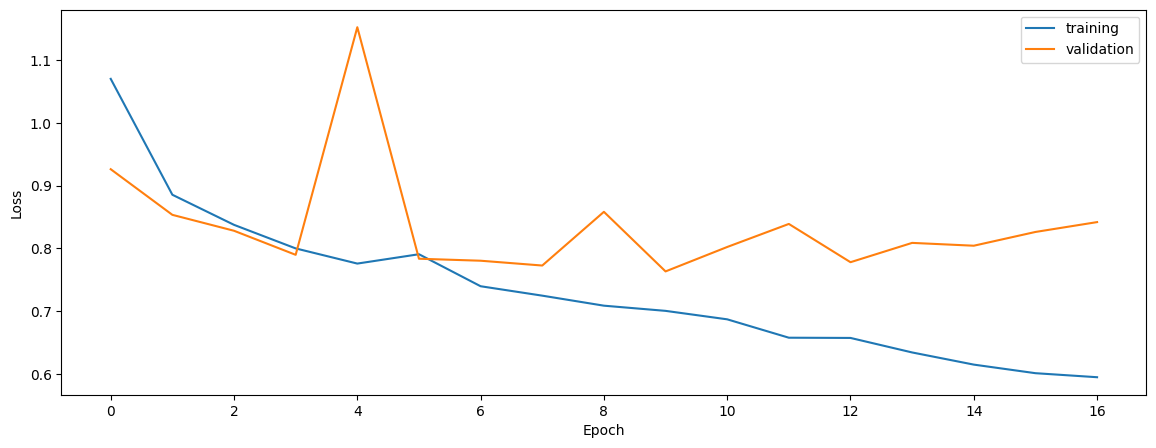

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


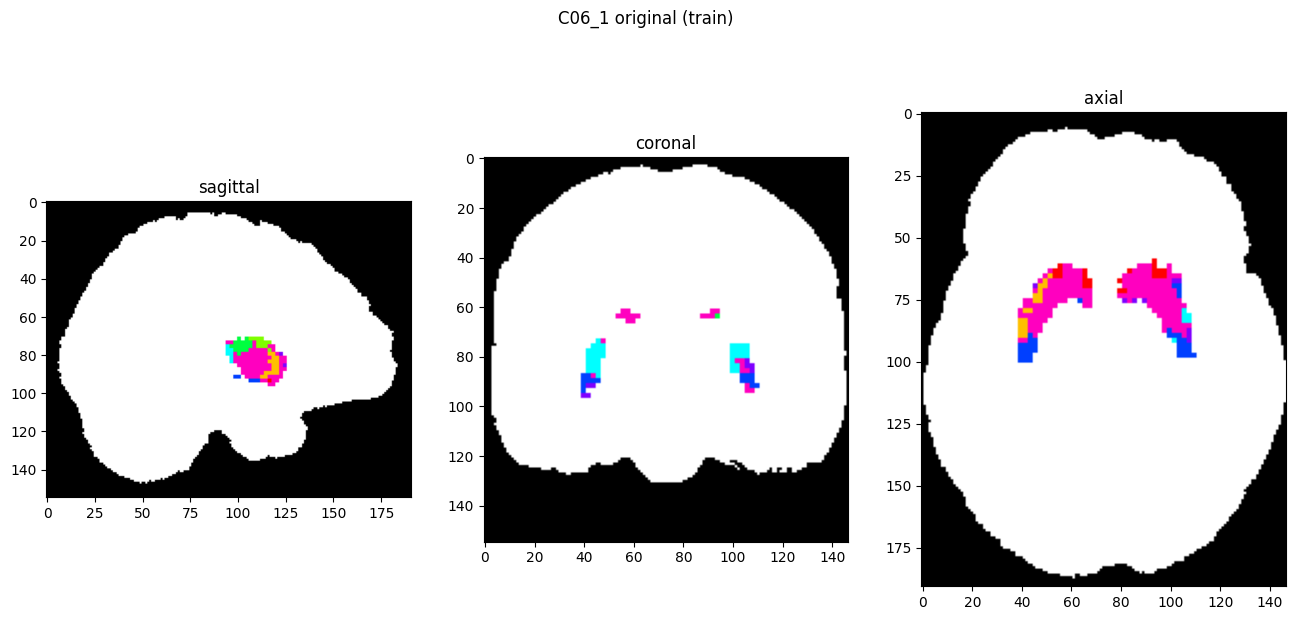

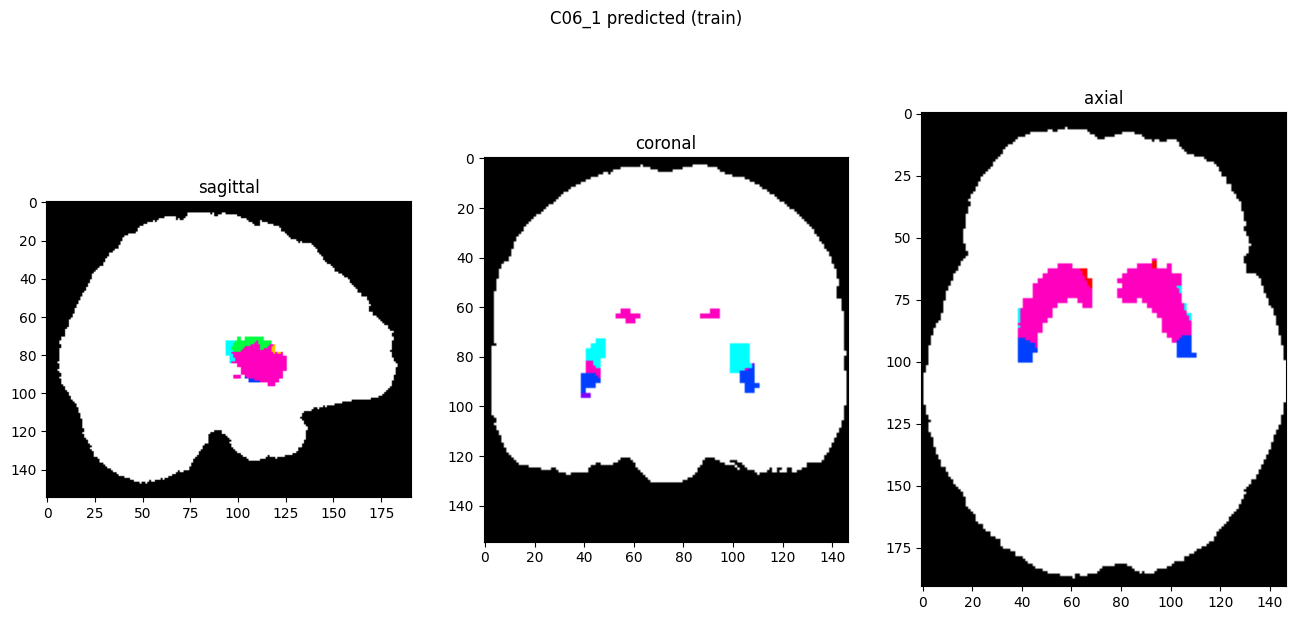

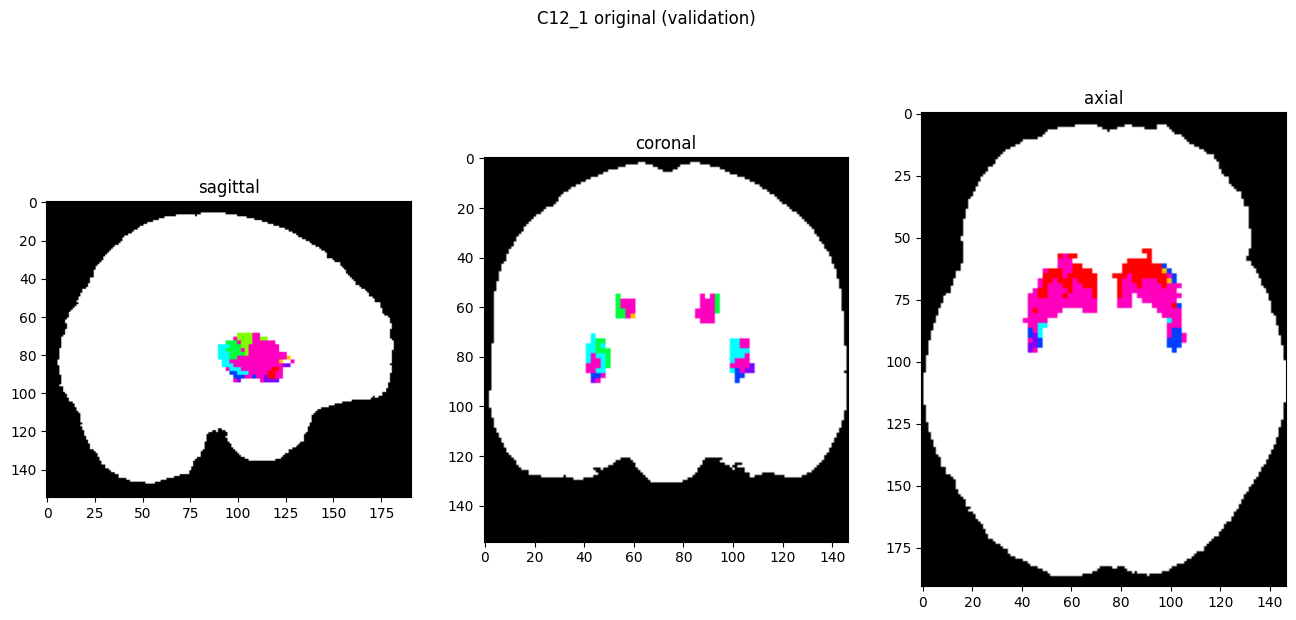

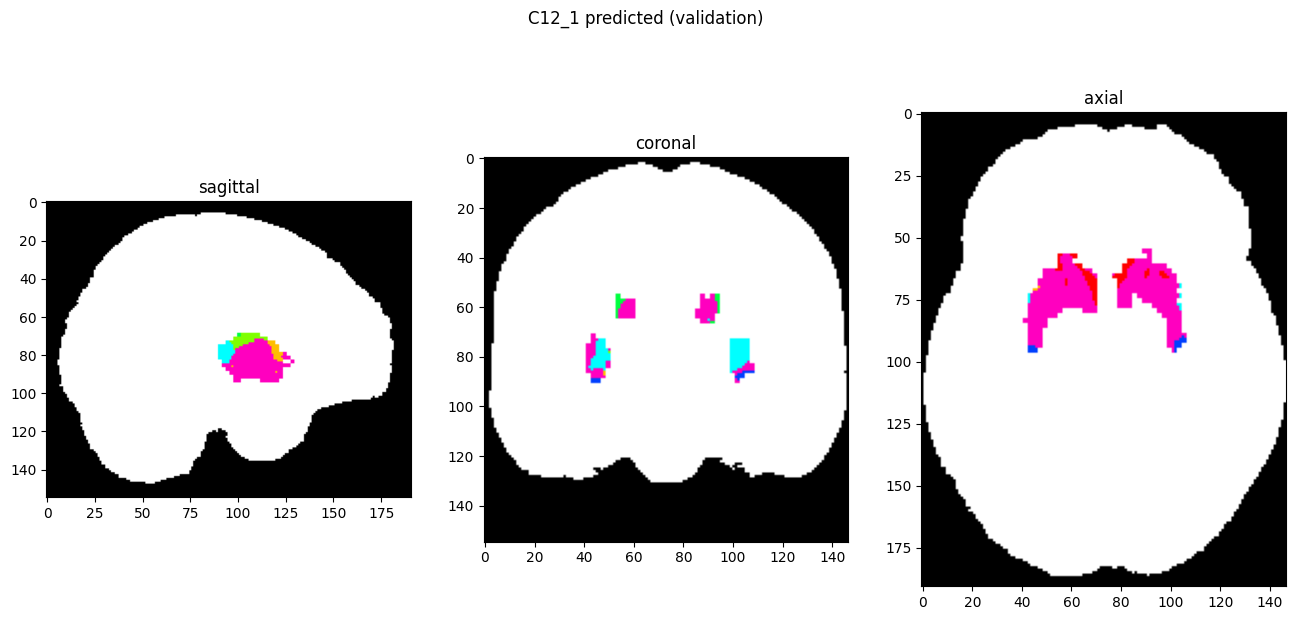

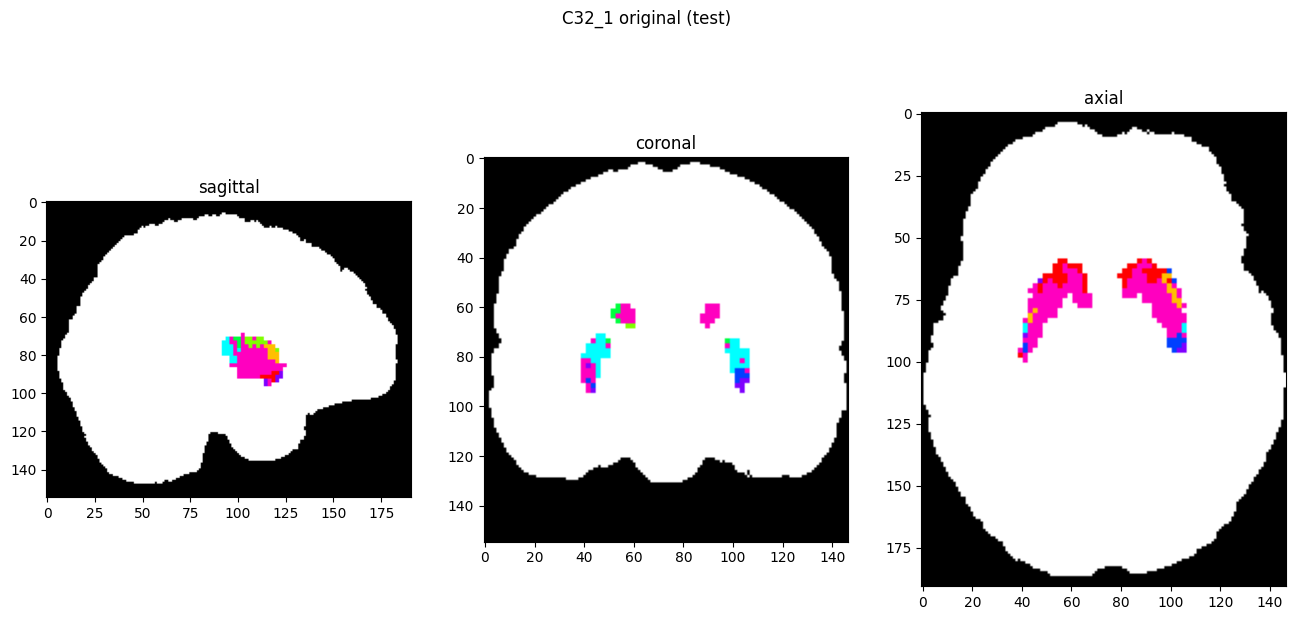

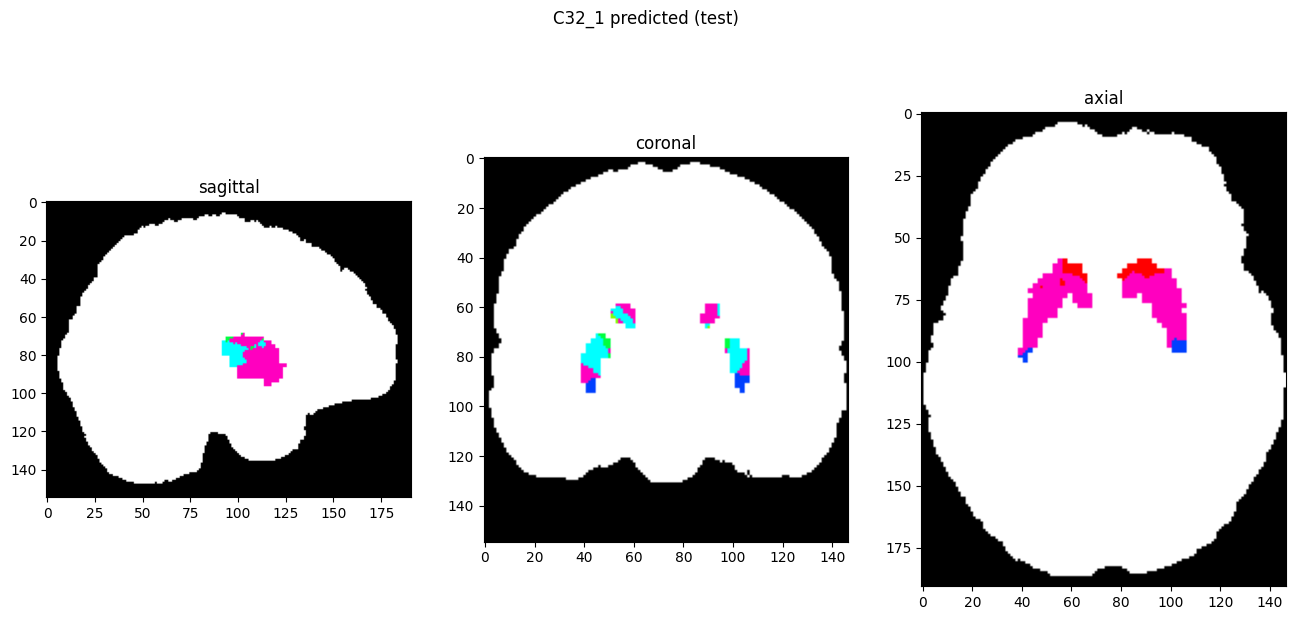

In [10]:
showResults(model, gen, threshold=0)